# Neural Network Model (Standardized with pre_processing.py)
This notebook uses the unified preprocessing functions from `pre_processing.py` to load a detailed, symmetric dataset for tournament games and then builds a neural network model using Keras and Keras Tuner (Hyperband) with rolling window cross-validation. The NN feature set is standardized to include:
- Team1 and Team2 win percentages (Team1WinPct, Team2WinPct)
- Last 14-game win rates (Team1Last14WinRate, Team2Last14WinRate)
- Team quality metrics (Team1Quality, Team2Quality)
- Seed difference (SeedDiff)

The evaluation uses our common `rolling_window_cv` function.

Imports and Preprocessing Imports

In [13]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# TensorFlow GPU specific warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # Suppresses info and warning messages

# Suppress specific Keras warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras")

# Evaluation metrics
from sklearn.metrics import log_loss, brier_score_loss, accuracy_score
from sklearn.calibration import calibration_curve

# TensorFlow / Keras for building the neural network
import tensorflow as tf
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Keras Tuner for hyperparameter tuning
import keras_tuner as kt
from keras_tuner import Hyperband

if os.path.exists('/kaggle/input'):
    sys.path.append('/kaggle/input/preprocessing-module')
else:
    sys.path.append('../../scripts')

# Import our unified preprocessing functions
from pre_processing import build_model_pipeline, rolling_window_cv

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load Data using build_model_pipeline (model_type 'nn')
 
This will force detailed data with symmetry and include the necessary features for the NN.

In [14]:
# Load the preprocessed feature matrix and target vector tailored for the neural network model
# Includes all relevant features as well as "Season" for time-based cross-validation
X_nn, y_nn, game_ids = build_model_pipeline(model_type='nn')


# Inspect the first few rows (note that "Season" is included for CV splitting)
print("NN Feature DataFrame (first 5 rows):")
print(X_nn.head(5))
print("\nTarget Distribution:")
print(y_nn.value_counts())

Team quality estimates (head):
     TeamID    quality  Season
0     1112  10.855684    2003
1     1113  -3.653788    2003
2     1120 -11.358658    2003
3     1122 -14.606224    2003
4     1139 -13.447463    2003
5     1140  -6.718979    2003
6     1143   1.615490    2003
7     1153   3.825130    2003
8     1160   4.503993    2003
9     1161 -13.007249    2003
10    1163   7.890978    2003
11    1166   7.464000    2003
12    1173   3.982977    2003
13    1181   2.765712    2003
14    1190 -21.660584    2003
15    1196   6.564701    2003
16    1211  -1.934198    2003
17    1221 -12.306803    2003
18    1228   5.766804    2003
19    1231  -3.674315    2003
NN Feature DataFrame (first 5 rows):
   Season  Team1WinPct  Team2WinPct  Team1Last14WinRate  Team2Last14WinRate  \
0    2003     0.448276     0.600000            1.000000            0.833333   
1    2003     0.892857     0.655172            0.666667            1.000000   
2    2003     0.620690     0.793103            0.666667         

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


# Define the Keras Model Builder Function

This function builds a Keras model using hyperparameters from Keras Tuner. The input shape is based on the NN predictor features (all columns except 'Season').

In [15]:
# The input dimension is fixed based on the feature set
INPUT_DIM = 7  # 7 features excluding Season

def build_model_hp(hp):
    """
    Build a simplified Keras model with limited hyperparameter search space
    """
    model = Sequential([
        # First layer with fixed regularization
        Dense(
            units=16,  # Fixed size to reduce search space
            activation='relu',
            input_shape=(INPUT_DIM,),
            kernel_initializer='glorot_uniform',
            kernel_regularizer=l2(1e-4)
        ),
        BatchNormalization(),
        Dropout(rate=hp.Float('dropout_1', min_value=0.1, max_value=0.3, step=0.1)),
        
        # Output layer
        Dense(1, activation='sigmoid')
    ])
    
    # Fixed learning rate to avoid instability
    optimizer = Adam(
        learning_rate=1e-3,
        clipnorm=1.0
    )
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Define the NN Model Function for Rolling CV

This function uses Keras Tuner (Hyperband) to tune hyperparameters on the training set, trains the final model with the best hyperparameters, and evaluates it on the test set. The 'Season' column is dropped before training.

In [16]:
def nn_model_fn(X_train, y_train, X_test, y_test, test_season, model_params=None, sample_weight=None):
    """
    For a given CV fold (training and test sets defined by season), this function:
      1. Uses Hyperband to tune hyperparameters on the training data.
      2. Trains a final model with the best hyperparameters.
      3. Evaluates the model on the test data.
      4. Plots the calibration curve for this season.
    """
    # Process features, checking if Season column exists before dropping
    X_train_proc = X_train.copy()
    X_test_proc = X_test.copy()
    
    # Drop Season column if it exists
    if 'Season' in X_train_proc.columns:
        X_train_proc = X_train_proc.drop(columns=['Season'])
    if 'Season' in X_test_proc.columns:
        X_test_proc = X_test_proc.drop(columns=['Season'])
    
    # Print data info before handling nulls
    print(f"\nFeature information for season {test_season}:")
    print("\nTraining data null counts:")
    print(X_train_proc.isnull().sum())
    print("\nTest data null counts:")
    print(X_test_proc.isnull().sum())
    
    # Fill null values with appropriate defaults
    fill_values = {
        'Team1WinPct': 0.5,
        'Team2WinPct': 0.5,
        'Team1Last14WinRate': 0.5,
        'Team2Last14WinRate': 0.5,
        'Team1Quality': 0.0,
        'Team2Quality': 0.0,
        'SeedDiff': 0.0
    }
    
    X_train_proc = X_train_proc.fillna(fill_values)
    X_test_proc = X_test_proc.fillna(fill_values)
    
    # Validate data after filling nulls
    if X_train_proc.shape[1] != X_test_proc.shape[1]:
        raise ValueError("Training and test data have different number of features")
        
    # Standardize features
    feature_means = X_train_proc.mean()
    feature_stds = X_train_proc.std()
    feature_stds = feature_stds.replace(0, 1)  # Replace any zero standard deviations with 1
    X_train_proc = (X_train_proc - feature_means) / feature_stds
    X_test_proc = (X_test_proc - feature_means) / feature_stds
    
    # Print data ranges after standardization
    print("\nFeature ranges after standardization:")
    print("\nTraining data:")
    print(X_train_proc.describe())
    print("\nTest data:")
    print(X_test_proc.describe())
    
    # Convert to numpy arrays
    X_train_proc = X_train_proc.values
    X_test_proc = X_test_proc.values
    
    # Clear any existing Keras backend session
    tf.keras.backend.clear_session()
    
    # Early stopping callback with increased patience
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        min_delta=1e-4
    )
    
    # Reduce LR on plateau callback
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=0
    )
    
    try:
        # Print shape information for debugging
        print(f"\nTraining data shape for season {test_season}: {X_train_proc.shape}")
        print(f"Test data shape for season {test_season}: {X_test_proc.shape}")
        
        # Use Hyperband tuner with modified parameters
        tuner = Hyperband(
            build_model_hp,
            objective=kt.Objective('val_loss', direction='min'),
            max_epochs=50,
            factor=3,
            hyperband_iterations=2,
            directory='nn_tuner_dir',
            project_name=f"season_{test_season}_tuning",
            overwrite=True,
            seed=42
        )
        
        # Perform hyperparameter search with validation split
        tuner.search(
            X_train_proc,
            y_train,
            epochs=50,
            batch_size=32,
            validation_split=0.2,
            callbacks=[early_stopping, reduce_lr],
            verbose=0
        )
        
        best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
        print(f"Season {test_season} - Best Hyperparameters:")
        print(f"  dropout_1: {best_hps.get('dropout_1')}")
        
        # Build and train the final model with the best hyperparameters
        model = build_model_hp(best_hps)
        
        # Add class weights to handle any class imbalance
        n_pos = sum(y_train)
        n_neg = len(y_train) - n_pos
        class_weights = {
            0: len(y_train) / (2 * n_neg),
            1: len(y_train) / (2 * n_pos)
        }
        if isinstance(y_train, pd.Series):
             y_train = y_train.values
        
        history = model.fit(
            X_train_proc,
            y_train,
            epochs=100,
            batch_size=32,
            validation_split=0.2,
            callbacks=[early_stopping],
            class_weight=class_weights,
            verbose=0
        )
        
        # Predict on test data
        y_pred_prob = model.predict(X_test_proc, batch_size=32).flatten()
        y_pred_prob = np.clip(y_pred_prob, 1e-7, 1 - 1e-7)  # Clip probabilities
        y_pred_class = (y_pred_prob >= 0.5).astype(int)
        
        # Compute metrics
        acc = accuracy_score(y_test, y_pred_class)
        ll = log_loss(y_test, y_pred_prob)
        bri = brier_score_loss(y_test, y_pred_prob)
        
        print(f"\nTest Metrics for season {test_season}:")
        print(f"Accuracy: {acc:.3f}")
        print(f"Log Loss: {ll:.3f}")
        print(f"Brier Score: {bri:.3f}")
        
        # Plot calibration curve for this season
        prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=10)
        plt.figure(figsize=(8, 6))
        plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label="Calibration curve")
        plt.plot([0, 1], [0, 1], linestyle='--', label="Perfect calibration")
        plt.xlabel("Mean predicted probability")
        plt.ylabel("Fraction of positives")
        plt.title(f"Calibration Curve (Season {test_season})")
        plt.legend()
        plt.show()
        
        return {"accuracy": acc, "logloss": ll, "brier": bri}
    
    except Exception as e:
        print(f"Error during training for season {test_season}: {str(e)}")
        print("Full error details:", str(e.__class__.__name__), str(e))
        import traceback
        traceback.print_exc()
        # Return default metrics in case of failure
        return {"accuracy": 0.5, "logloss": 0.693, "brier": 0.25}

# Rolling Window Cross‑Validation Evaluation

We use the unified `rolling_window_cv` function from `pre_processing.py` with our `nn_model_fn`. The 'Season' column is used for splitting the dataset into training and test sets.


Feature information for season 2019:

Training data null counts:
Team1WinPct            0
Team2WinPct            0
Team1Last14WinRate     0
Team2Last14WinRate     0
Team1Quality          54
Team2Quality          54
SeedDiff               0
dtype: int64

Test data null counts:
Team1WinPct           0
Team2WinPct           0
Team1Last14WinRate    0
Team2Last14WinRate    0
Team1Quality          5
Team2Quality          5
SeedDiff              0
dtype: int64

Feature ranges after standardization:

Training data:
        Team1WinPct   Team2WinPct  Team1Last14WinRate  Team2Last14WinRate  \
count  3.230000e+03  3.230000e+03        3.230000e+03        3.230000e+03   
mean  -1.583872e-16 -1.407887e-16        3.519716e-16        3.563713e-16   
std    1.000000e+00  1.000000e+00        1.000000e+00        1.000000e+00   
min   -3.702121e+00 -3.702121e+00       -2.703547e+00       -2.703547e+00   
25%   -7.073625e-01 -7.073625e-01       -8.198412e-01       -8.198412e-01   
50%    1.330141e-02  1.3

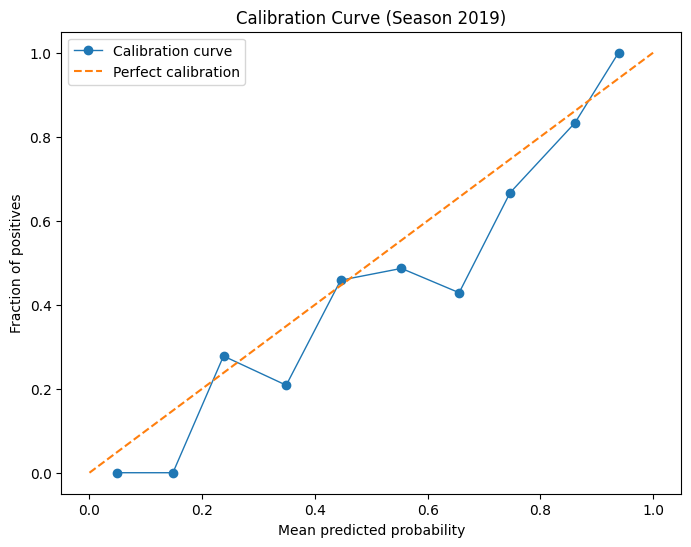

Season 2019 – Accuracy: 0.723, Log Loss: 0.498, Brier: 0.169

Feature information for season 2021:

Training data null counts:
Team1WinPct            0
Team2WinPct            0
Team1Last14WinRate     0
Team2Last14WinRate     0
Team1Quality          59
Team2Quality          59
SeedDiff               0
dtype: int64

Test data null counts:
Team1WinPct            0
Team2WinPct            0
Team1Last14WinRate     0
Team2Last14WinRate     0
Team1Quality          13
Team2Quality          13
SeedDiff               0
dtype: int64

Feature ranges after standardization:

Training data:
        Team1WinPct   Team2WinPct  Team1Last14WinRate  Team2Last14WinRate  \
count  3.490000e+03  3.490000e+03        3.490000e+03        3.490000e+03   
mean  -3.257503e-17 -3.257503e-17       -6.515005e-17       -4.479066e-17   
std    1.000000e+00  1.000000e+00        1.000000e+00        1.000000e+00   
min   -3.709829e+00 -3.709829e+00       -2.697440e+00       -2.697440e+00   
25%   -7.143681e-01 -7.143681e-01

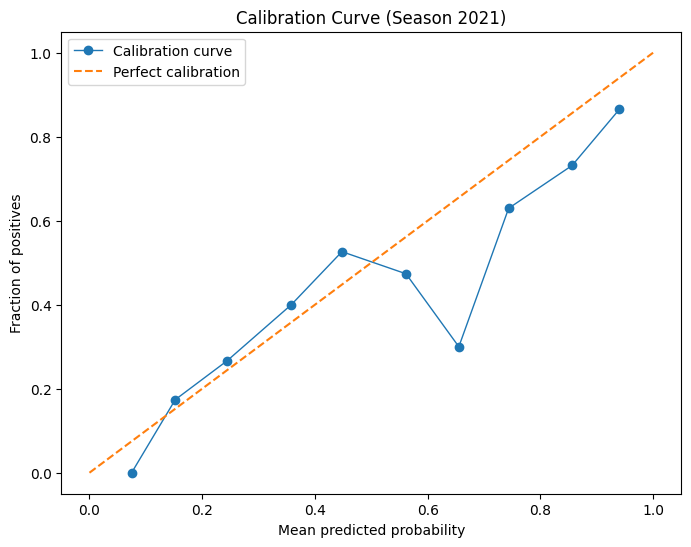

Season 2021 – Accuracy: 0.655, Log Loss: 0.618, Brier: 0.213

Feature information for season 2022:

Training data null counts:
Team1WinPct            0
Team2WinPct            0
Team1Last14WinRate     0
Team2Last14WinRate     0
Team1Quality          72
Team2Quality          72
SeedDiff               0
dtype: int64

Test data null counts:
Team1WinPct           0
Team2WinPct           0
Team1Last14WinRate    0
Team2Last14WinRate    0
Team1Quality          4
Team2Quality          4
SeedDiff              0
dtype: int64

Feature ranges after standardization:

Training data:
        Team1WinPct   Team2WinPct  Team1Last14WinRate  Team2Last14WinRate  \
count  3.748000e+03  3.748000e+03        3.748000e+03        3.748000e+03   
mean  -1.819960e-16 -1.971623e-16       -3.450341e-16        5.687375e-17   
std    1.000000e+00  1.000000e+00        1.000000e+00        1.000000e+00   
min   -3.669269e+00 -3.669269e+00       -2.681033e+00       -2.681033e+00   
25%   -6.999265e-01 -6.999265e-01       

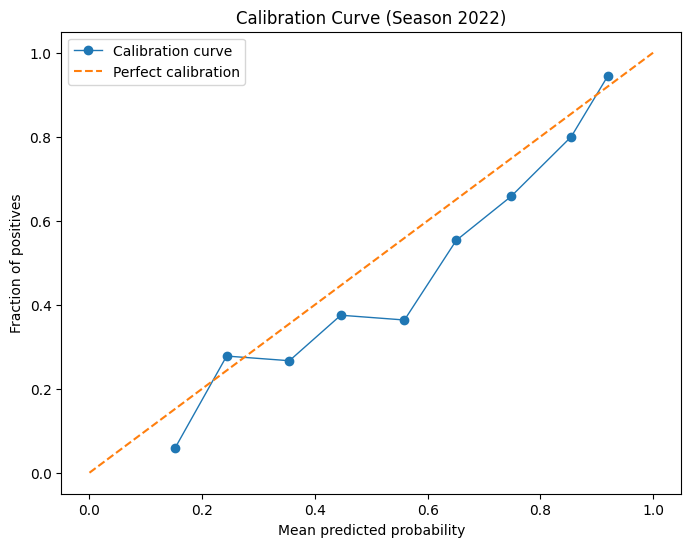

Season 2022 – Accuracy: 0.668, Log Loss: 0.599, Brier: 0.207

Feature information for season 2023:

Training data null counts:
Team1WinPct            0
Team2WinPct            0
Team1Last14WinRate     0
Team2Last14WinRate     0
Team1Quality          76
Team2Quality          76
SeedDiff               0
dtype: int64

Test data null counts:
Team1WinPct           0
Team2WinPct           0
Team1Last14WinRate    0
Team2Last14WinRate    0
Team1Quality          5
Team2Quality          5
SeedDiff              0
dtype: int64

Feature ranges after standardization:

Training data:
        Team1WinPct   Team2WinPct  Team1Last14WinRate  Team2Last14WinRate  \
count  4.016000e+03  4.016000e+03        4.016000e+03        4.016000e+03   
mean  -4.529356e-16 -4.812441e-16       -6.369407e-17       -8.492543e-17   
std    1.000000e+00  1.000000e+00        1.000000e+00        1.000000e+00   
min   -3.690631e+00 -3.690631e+00       -2.622130e+00       -2.622130e+00   
25%   -7.000983e-01 -7.000983e-01       

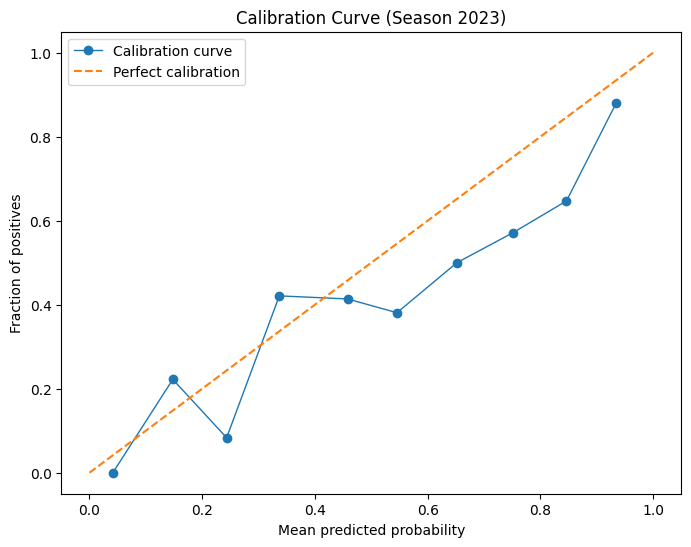

Season 2023 – Accuracy: 0.642, Log Loss: 0.639, Brier: 0.224

Overall average metrics: Accuracy: 0.672, Log Loss: 0.588, Brier: 0.203

Overall NN CV Metrics:
        accuracy   logloss     brier
season                              
2019    0.723077  0.497722  0.169328
2021    0.655039  0.617965  0.213158
2022    0.667910  0.599265  0.207259
2023    0.641791  0.638824  0.224214


In [17]:
# Set CV to start from season 2019.
start_season = 2018

cv_metrics_nn = rolling_window_cv(
    X = X_nn,    # X_nn includes the "Season" column for splitting
    y = y_nn,
    start_season = start_season,
    window_size = None,  # Use all available data prior to the test season
    model_fn = nn_model_fn,
    verbose = True
)

print("\nOverall NN CV Metrics:")
print(cv_metrics_nn)

Team quality estimates (head):
     TeamID    quality  Season
0     1112  10.855684    2003
1     1113  -3.653788    2003
2     1120 -11.358658    2003
3     1122 -14.606224    2003
4     1139 -13.447463    2003
5     1140  -6.718979    2003
6     1143   1.615490    2003
7     1153   3.825130    2003
8     1160   4.503993    2003
9     1161 -13.007249    2003
10    1163   7.890978    2003
11    1166   7.464000    2003
12    1173   3.982977    2003
13    1181   2.765712    2003
14    1190 -21.660584    2003
15    1196   6.564701    2003
16    1211  -1.934198    2003
17    1221 -12.306803    2003
18    1228   5.766804    2003
19    1231  -3.674315    2003

Feature information for season 2018:

Training data null counts:
Team1WinPct            0
Team2WinPct            0
Team1Last14WinRate     0
Team2Last14WinRate     0
Team1Quality          50
Team2Quality          50
SeedDiff               0
dtype: int64

Test data null counts:
Team1WinPct           0
Team2WinPct           0
Team1Last14W

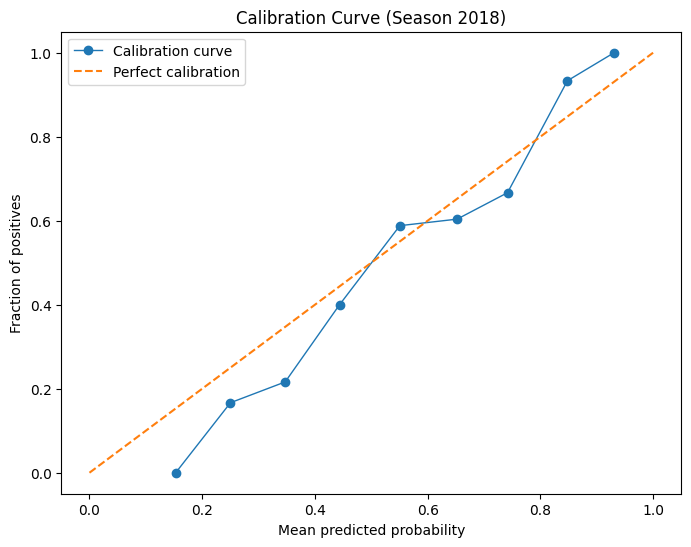


Feature information for season 2019:

Training data null counts:
Team1WinPct            0
Team2WinPct            0
Team1Last14WinRate     0
Team2Last14WinRate     0
Team1Quality          54
Team2Quality          54
SeedDiff               0
dtype: int64

Test data null counts:
Team1WinPct           0
Team2WinPct           0
Team1Last14WinRate    0
Team2Last14WinRate    0
Team1Quality          5
Team2Quality          5
SeedDiff              0
dtype: int64

Feature ranges after standardization:

Training data:
        Team1WinPct   Team2WinPct  Team1Last14WinRate  Team2Last14WinRate  \
count  3.230000e+03  3.230000e+03        3.230000e+03        3.230000e+03   
mean  -1.583872e-16 -1.407887e-16        3.519716e-16        3.563713e-16   
std    1.000000e+00  1.000000e+00        1.000000e+00        1.000000e+00   
min   -3.702121e+00 -3.702121e+00       -2.703547e+00       -2.703547e+00   
25%   -7.073625e-01 -7.073625e-01       -8.198412e-01       -8.198412e-01   
50%    1.330141e-02  1.3

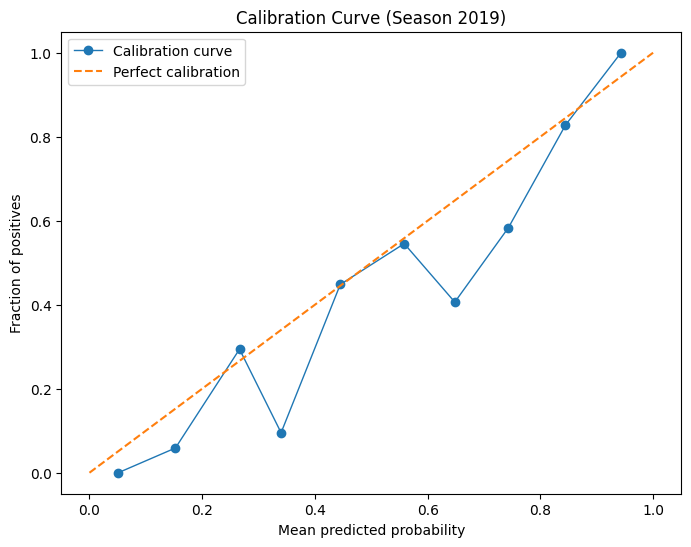


Feature information for season 2021:

Training data null counts:
Team1WinPct            0
Team2WinPct            0
Team1Last14WinRate     0
Team2Last14WinRate     0
Team1Quality          59
Team2Quality          59
SeedDiff               0
dtype: int64

Test data null counts:
Team1WinPct            0
Team2WinPct            0
Team1Last14WinRate     0
Team2Last14WinRate     0
Team1Quality          13
Team2Quality          13
SeedDiff               0
dtype: int64

Feature ranges after standardization:

Training data:
        Team1WinPct   Team2WinPct  Team1Last14WinRate  Team2Last14WinRate  \
count  3.490000e+03  3.490000e+03        3.490000e+03        3.490000e+03   
mean  -3.257503e-17 -3.257503e-17       -6.515005e-17       -4.479066e-17   
std    1.000000e+00  1.000000e+00        1.000000e+00        1.000000e+00   
min   -3.709829e+00 -3.709829e+00       -2.697440e+00       -2.697440e+00   
25%   -7.143681e-01 -7.143681e-01       -8.178045e-01       -8.178045e-01   
50%    6.464691e-

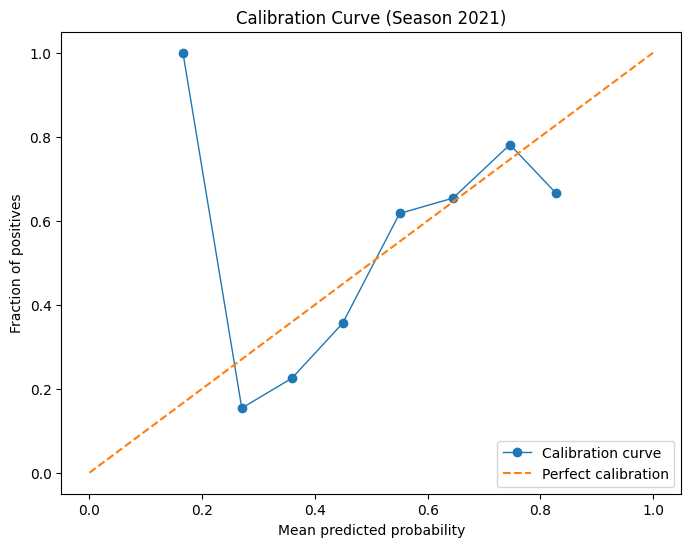


Feature information for season 2022:

Training data null counts:
Team1WinPct            0
Team2WinPct            0
Team1Last14WinRate     0
Team2Last14WinRate     0
Team1Quality          72
Team2Quality          72
SeedDiff               0
dtype: int64

Test data null counts:
Team1WinPct           0
Team2WinPct           0
Team1Last14WinRate    0
Team2Last14WinRate    0
Team1Quality          4
Team2Quality          4
SeedDiff              0
dtype: int64

Feature ranges after standardization:

Training data:
        Team1WinPct   Team2WinPct  Team1Last14WinRate  Team2Last14WinRate  \
count  3.748000e+03  3.748000e+03        3.748000e+03        3.748000e+03   
mean  -1.819960e-16 -1.971623e-16       -3.450341e-16        5.687375e-17   
std    1.000000e+00  1.000000e+00        1.000000e+00        1.000000e+00   
min   -3.669269e+00 -3.669269e+00       -2.681033e+00       -2.681033e+00   
25%   -6.999265e-01 -6.999265e-01       -8.120126e-01       -8.120126e-01   
50%    1.462117e-02  1.4

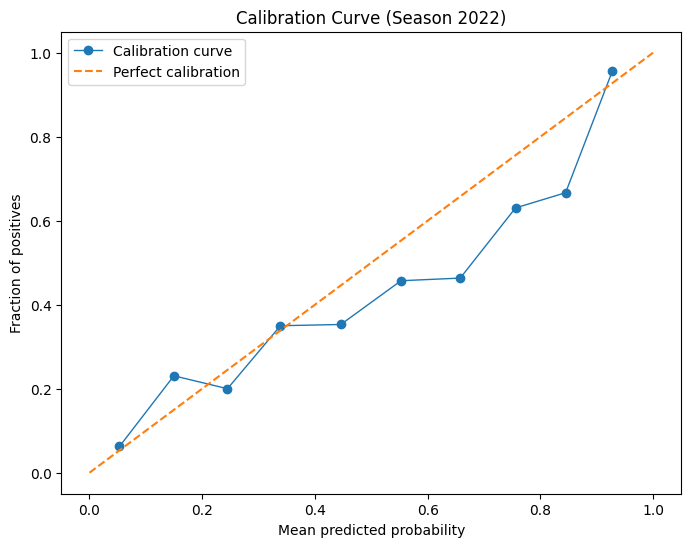


Feature information for season 2018:

Training data null counts:
Team1WinPct            0
Team2WinPct            0
Team1Last14WinRate     0
Team2Last14WinRate     0
Team1Quality          23
Team2Quality          23
SeedDiff               0
dtype: int64

Test data null counts:
Team1WinPct           0
Team2WinPct           0
Team1Last14WinRate    0
Team2Last14WinRate    0
Team1Quality          4
Team2Quality          4
SeedDiff              0
dtype: int64

Feature ranges after standardization:

Training data:
        Team1WinPct   Team2WinPct  Team1Last14WinRate  Team2Last14WinRate  \
count  1.300000e+03  1.300000e+03        1.300000e+03        1.300000e+03   
mean   2.404914e-16  2.186285e-16        3.825999e-17       -3.607371e-16   
std    1.000000e+00  1.000000e+00        1.000000e+00        1.000000e+00   
min   -3.609195e+00 -3.609195e+00       -2.513746e+00       -2.513746e+00   
25%   -6.966849e-01 -6.966849e-01       -7.269649e-01       -7.269649e-01   
50%    4.186349e-03  4.1

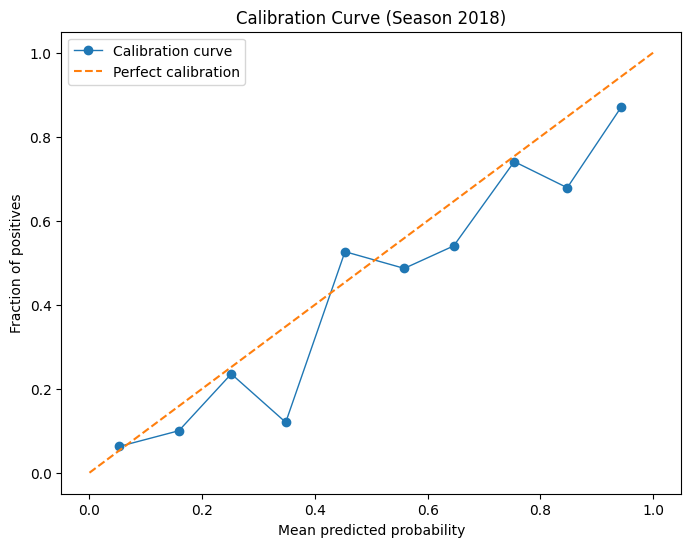


Feature information for season 2019:

Training data null counts:
Team1WinPct            0
Team2WinPct            0
Team1Last14WinRate     0
Team2Last14WinRate     0
Team1Quality          25
Team2Quality          25
SeedDiff               0
dtype: int64

Test data null counts:
Team1WinPct           0
Team2WinPct           0
Team1Last14WinRate    0
Team2Last14WinRate    0
Team1Quality          5
Team2Quality          5
SeedDiff              0
dtype: int64

Feature ranges after standardization:

Training data:
        Team1WinPct   Team2WinPct  Team1Last14WinRate  Team2Last14WinRate  \
count  1.300000e+03  1.300000e+03        1.300000e+03        1.300000e+03   
mean  -5.028456e-16  5.028456e-16        2.623542e-16       -8.745141e-17   
std    1.000000e+00  1.000000e+00        1.000000e+00        1.000000e+00   
min   -3.558512e+00 -3.558512e+00       -2.459071e+00       -2.459071e+00   
25%   -6.851177e-01 -6.851177e-01       -7.132849e-01       -7.132849e-01   
50%    6.340859e-03  6.3

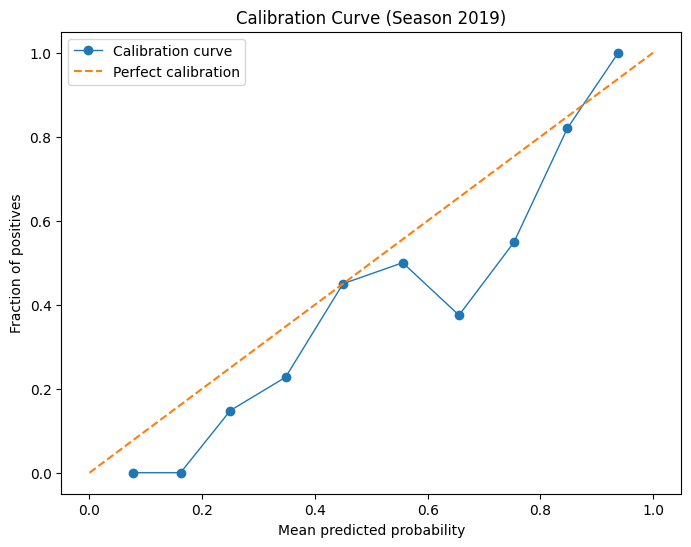


Feature information for season 2021:

Training data null counts:
Team1WinPct            0
Team2WinPct            0
Team1Last14WinRate     0
Team2Last14WinRate     0
Team1Quality          26
Team2Quality          26
SeedDiff               0
dtype: int64

Test data null counts:
Team1WinPct            0
Team2WinPct            0
Team1Last14WinRate     0
Team2Last14WinRate     0
Team1Quality          13
Team2Quality          13
SeedDiff               0
dtype: int64

Feature ranges after standardization:

Training data:
        Team1WinPct   Team2WinPct  Team1Last14WinRate  Team2Last14WinRate  \
count  1.040000e+03  1.040000e+03        1.040000e+03        1.040000e+03   
mean   1.339100e-15  1.339100e-15       -2.664535e-16       -2.322928e-16   
std    1.000000e+00  1.000000e+00        1.000000e+00        1.000000e+00   
min   -3.164711e+00 -3.164711e+00       -2.426137e+00       -2.426137e+00   
25%   -7.144791e-01 -7.144791e-01       -6.976311e-01       -6.976311e-01   
50%    9.240861e-

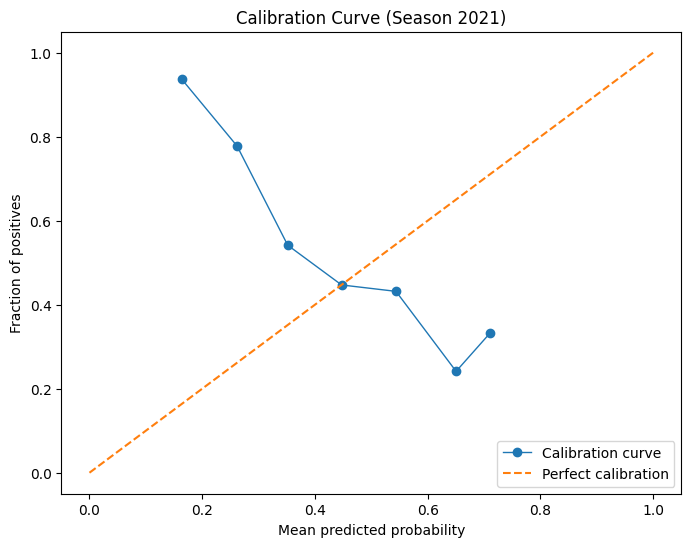


Feature information for season 2022:

Training data null counts:
Team1WinPct            0
Team2WinPct            0
Team1Last14WinRate     0
Team2Last14WinRate     0
Team1Quality          34
Team2Quality          34
SeedDiff               0
dtype: int64

Test data null counts:
Team1WinPct           0
Team2WinPct           0
Team1Last14WinRate    0
Team2Last14WinRate    0
Team1Quality          4
Team2Quality          4
SeedDiff              0
dtype: int64

Feature ranges after standardization:

Training data:
        Team1WinPct   Team2WinPct  Team1Last14WinRate  Team2Last14WinRate  \
count  1.038000e+03  1.038000e+03        1.038000e+03        1.038000e+03   
mean  -3.970277e-16  6.023869e-16        1.095249e-16        2.156271e-16   
std    1.000000e+00  1.000000e+00        1.000000e+00        1.000000e+00   
min   -2.905580e+00 -2.905580e+00       -2.501189e+00       -2.501189e+00   
25%   -7.749973e-01 -7.749973e-01       -7.363412e-01       -7.363412e-01   
50%    2.988946e-02  2.9

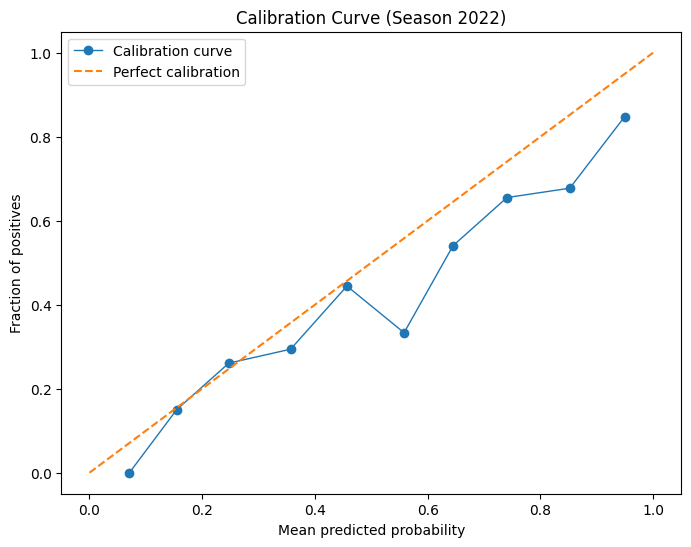


Feature information for season 2018:

Training data null counts:
Team1WinPct            0
Team2WinPct            0
Team1Last14WinRate     0
Team2Last14WinRate     0
Team1Quality          12
Team2Quality          12
SeedDiff               0
dtype: int64

Test data null counts:
Team1WinPct           0
Team2WinPct           0
Team1Last14WinRate    0
Team2Last14WinRate    0
Team1Quality          4
Team2Quality          4
SeedDiff              0
dtype: int64

Feature ranges after standardization:

Training data:
        Team1WinPct   Team2WinPct  Team1Last14WinRate  Team2Last14WinRate  \
count  2.600000e+02  2.600000e+02        2.600000e+02        2.600000e+02   
mean   2.049643e-16  1.913000e-16       -1.844678e-16       -1.776357e-16   
std    1.000000e+00  1.000000e+00        1.000000e+00        1.000000e+00   
min   -2.524187e+00 -2.524187e+00       -2.404460e+00       -2.404460e+00   
25%   -7.687028e-01 -7.687028e-01       -6.851667e-01       -6.851667e-01   
50%   -3.491611e-03 -3.4

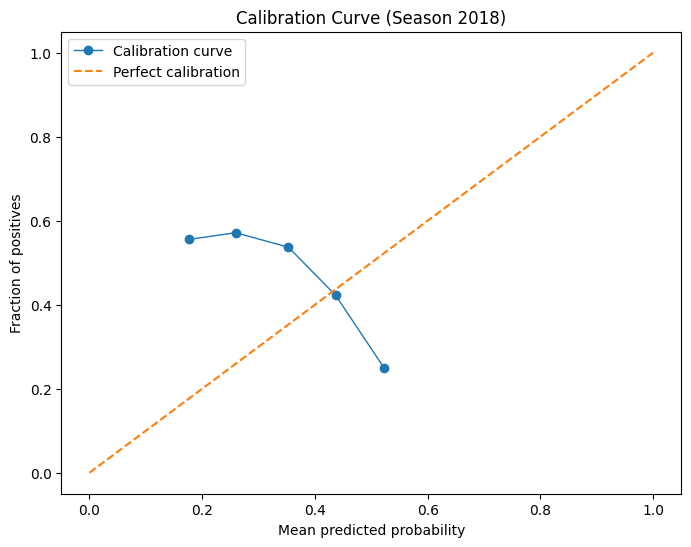


Feature information for season 2019:

Training data null counts:
Team1WinPct           0
Team2WinPct           0
Team1Last14WinRate    0
Team2Last14WinRate    0
Team1Quality          4
Team2Quality          4
SeedDiff              0
dtype: int64

Test data null counts:
Team1WinPct           0
Team2WinPct           0
Team1Last14WinRate    0
Team2Last14WinRate    0
Team1Quality          5
Team2Quality          5
SeedDiff              0
dtype: int64

Feature ranges after standardization:

Training data:
        Team1WinPct   Team2WinPct  Team1Last14WinRate  Team2Last14WinRate  \
count  2.600000e+02  2.600000e+02        2.600000e+02        2.600000e+02   
mean   2.732857e-16  2.186285e-16        3.142785e-16        2.562053e-16   
std    1.000000e+00  1.000000e+00        1.000000e+00        1.000000e+00   
min   -2.903819e+00 -2.903819e+00       -2.500197e+00       -2.500197e+00   
25%   -6.746086e-01 -6.746086e-01       -7.284575e-01       -7.284575e-01   
50%    1.099620e-01  1.099620e-

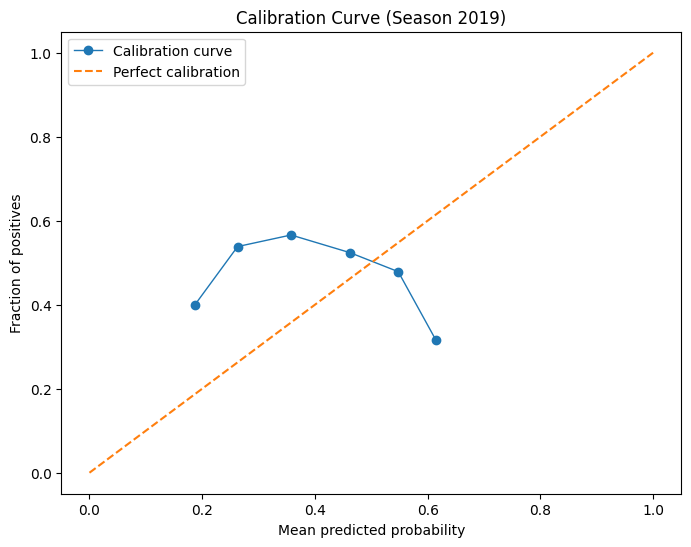


Feature information for season 2022:

Training data null counts:
Team1WinPct            0
Team2WinPct            0
Team1Last14WinRate     0
Team2Last14WinRate     0
Team1Quality          13
Team2Quality          13
SeedDiff               0
dtype: int64

Test data null counts:
Team1WinPct           0
Team2WinPct           0
Team1Last14WinRate    0
Team2Last14WinRate    0
Team1Quality          4
Team2Quality          4
SeedDiff              0
dtype: int64

Feature ranges after standardization:

Training data:
        Team1WinPct   Team2WinPct  Team1Last14WinRate  Team2Last14WinRate  \
count  2.580000e+02  2.580000e+02        2.580000e+02        2.580000e+02   
mean  -6.058892e-16  3.029446e-16       -7.229359e-17        3.029446e-16   
std    1.000000e+00  1.000000e+00        1.000000e+00        1.000000e+00   
min   -2.098787e+00 -2.098787e+00       -2.478248e+00       -2.478248e+00   
25%   -8.129981e-01 -8.129981e-01       -7.403083e-01       -7.403083e-01   
50%   -1.193485e-01 -1.1

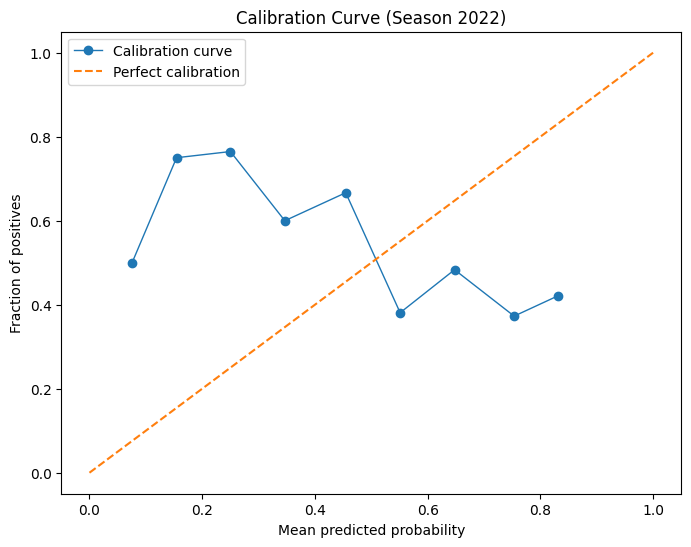

Neural Network Performance Comparison by Strategy:


,accuracy,logloss,brier,season,strategy
0,0.692308,0.595953,0.205202,2018,all
8,0.492308,0.772304,0.284967,2018,last1
4,0.688462,0.586307,0.198380,2018,last5
1,0.730769,0.487812,0.166768,2019,all
9,0.457692,0.739834,0.271878,2019,last1
5,0.715385,0.515997,0.175451,2019,last5
2,0.682171,0.636632,0.221883,2021,all
6,0.406977,0.852457,0.319250,2021,last5
3,0.652985,0.617472,0.216504,2022,all
10,0.388060,0.892983,0.335118,2022,last1


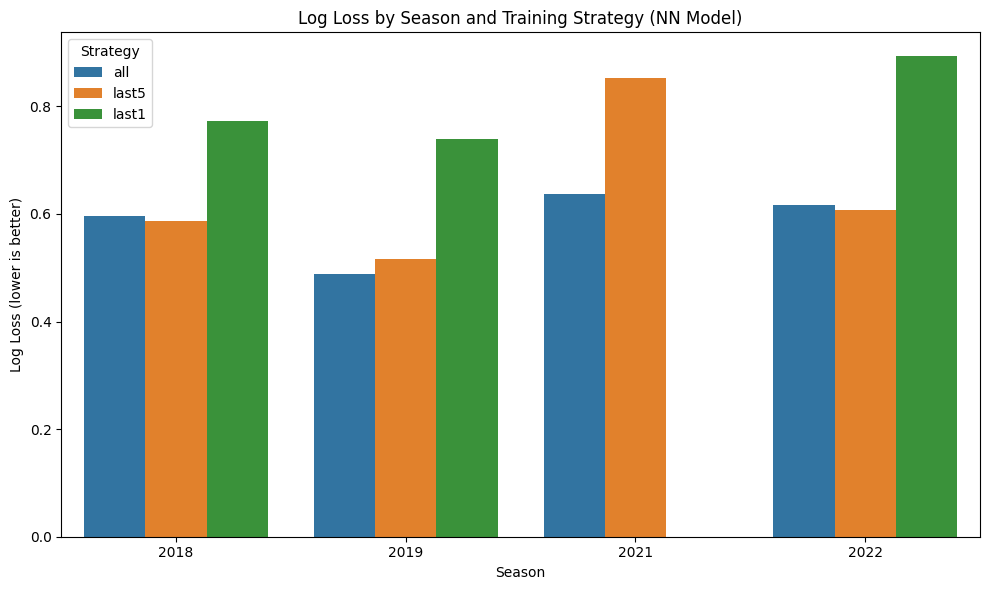

In [18]:
# === Compare NN Performance Across Training Strategies (All, Last 5, Last 1) ===
import seaborn as sns 
# Define function for strategy-based cross-validation
def rolling_window_strategy_comparison(X, y, seasons, model_fn, strategy):
    results = []
    for test_season in seasons:
        if strategy == 'all':
            train_mask = X['Season'] < test_season
        elif strategy == 'last5':
            train_mask = (X['Season'] >= test_season - 5) & (X['Season'] < test_season)
        elif strategy == 'last1':
            train_mask = X['Season'] == test_season - 1
        else:
            raise ValueError("Unknown strategy")

        test_mask = X['Season'] == test_season

        X_train, y_train = X[train_mask], y[train_mask]
        X_test, y_test = X[test_mask], y[test_mask]

        if len(X_train) == 0 or len(X_test) == 0:
            continue

        metrics = model_fn(X_train, y_train, X_test, y_test, test_season)
        metrics['season'] = test_season
        metrics['strategy'] = strategy
        results.append(metrics)
    return results

# Rebuild input data for consistency (if needed)
X_nn, y_nn, game_ids = build_model_pipeline(model_type='nn')

# Seasons to evaluate
seasons = list(range(2018, 2023))

# Run each strategy
results_all = rolling_window_strategy_comparison(X_nn, y_nn, seasons, nn_model_fn, strategy='all')
results_5yr = rolling_window_strategy_comparison(X_nn, y_nn, seasons, nn_model_fn, strategy='last5')
results_1yr = rolling_window_strategy_comparison(X_nn, y_nn, seasons, nn_model_fn, strategy='last1')

# Aggregate results
df_all = pd.DataFrame(results_all)
df_5yr = pd.DataFrame(results_5yr)
df_1yr = pd.DataFrame(results_1yr)
df_all_strategies = pd.concat([df_all, df_5yr, df_1yr], ignore_index=True)

# Display results table
print("Neural Network Performance Comparison by Strategy:")
display(df_all_strategies.sort_values(by=['season', 'strategy']))

# Optional: visualize log loss per season/strategy
plt.figure(figsize=(10, 6))
sns.barplot(data=df_all_strategies, x="season", y="logloss", hue="strategy")
plt.title("Log Loss by Season and Training Strategy (NN Model)")
plt.ylabel("Log Loss (lower is better)")
plt.xlabel("Season")
plt.legend(title="Strategy")
plt.tight_layout()
plt.show()
